## Préliminaire 

Dans un premier temps, il nous est proposé de calculer trois densités qui sont des produits de convolution. 

**Rappel théorique :** Si X et Y sont deux variables aléatoires indépendantes de densités respectives f et g, alors X + Y a pour densité f ⋆ g.

Ainsi, chaque ψ représente la densité de la somme Z = X + Y de deux variables aléatoires indépendantes.


In [63]:
#Configuration 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, gamma

# Seed fixe pour la reproductibilité des résultats
np.random.seed(30)

### Cas 1 : ψ₁ = f₁ ⋆ g₁ avec f₁ et g₁ uniformes sur [0,1]

Donc leur somme Z = X + Y suit une **Loi triangulaire** sur [0, 2].

**Domaine :** $[0, 2]$

$$
\psi_1(x) = \begin{cases}
x & \text{si } 0 \leq x \leq 1 \\
2 - x & \text{si } 1 < x \leq 2 \\
0 & \text{sinon}
\end{cases}
$$

In [64]:
# CAS 1: U[0,1] ⋆ U[0,1] 

def psi1(x):
    result = np.zeros_like(x)
    mask1 = (x >= 0) & (x <= 1)
    mask2 = (x > 1) & (x <= 2)
    result[mask1] = x[mask1]
    result[mask2] = 2 - x[mask2]
    return result

### Cas 2 : ψ₂ = f₂ ⋆ g₂ où f₂ = g₂ = mélange de gaussiennes

Ici **X** et **Y** sonnt des **mélanges de gaussiennes**. Comme chaque variable provient avec probabilité 0,5 de la composante de moyenne -2 ou +2, il y a **4 combinaisons possibles** pour (X,Y), chacune de probabilité 0,25.

On utilise alors la propriété que la somme de deux gaussiennes indépendantes est encore gaussienne :

$$N(\mu_1, \sigma^2) + N(\mu_2, \sigma^2) = N(\mu_1 + \mu_2, 2\sigma^2)$$

Ici, les variances sont 1/2, donc la somme a variance 1.

On obtient donc :

- N(-2, 1/2) + N(-2, 1/2) = **N(-4, 1)** (poids 0,25)
- N(-2, 1/2) + N(2, 1/2) = **N(0, 1)** (poids 0,25)
- N(2, 1/2) + N(-2, 1/2) = **N(0, 1)** (poids 0,25)
- N(2, 1/2) + N(2, 1/2) = **N(4, 1)** (poids 0,25)

Les deux composantes centrées en 0 se regroupent, donc :

$$\psi_2(x) = 0{,}25 \cdot \mathcal{N}(-4, 1) + 0{,}5 \cdot \mathcal{N}(0, 1) + 0{,}25 \cdot \mathcal{N}(4, 1)$$

**Intervalle :** $[-8, 8]$ parceque c'est là que la densité est significative

In [65]:
# CAS 2: Mélange gaussien ⋆ Mélange gaussien

def psi2(x):
    return 0.25*norm.pdf(x, -4, 1) + 0.5*norm.pdf(x, 0, 1) + 0.25*norm.pdf(x, 4, 1)

### Cas 3 : ψ₃ = f₃ ⋆ g₃ avec f₃ = Γ(4,1) et g₃ = Γ(3,1)

**Propriété importante :**

La somme de deux lois Gamma indépendantes ayant la même échelle est encore une Gamma :

$$\Gamma(a, 1) + \Gamma(b, 1) = \Gamma(a + b, 1)$$

Donc :

$$Z = X + Y \sim \Gamma(4 + 3, 1) = \Gamma(7, 1)$$

**Intervalle :** $[0, 20]$ 

In [66]:
# CAS 3: Γ(4,1) ⋆ Γ(3,1) = Γ(7,1)

def psi3(x):
    return gamma.pdf(x, a=7, scale=1)

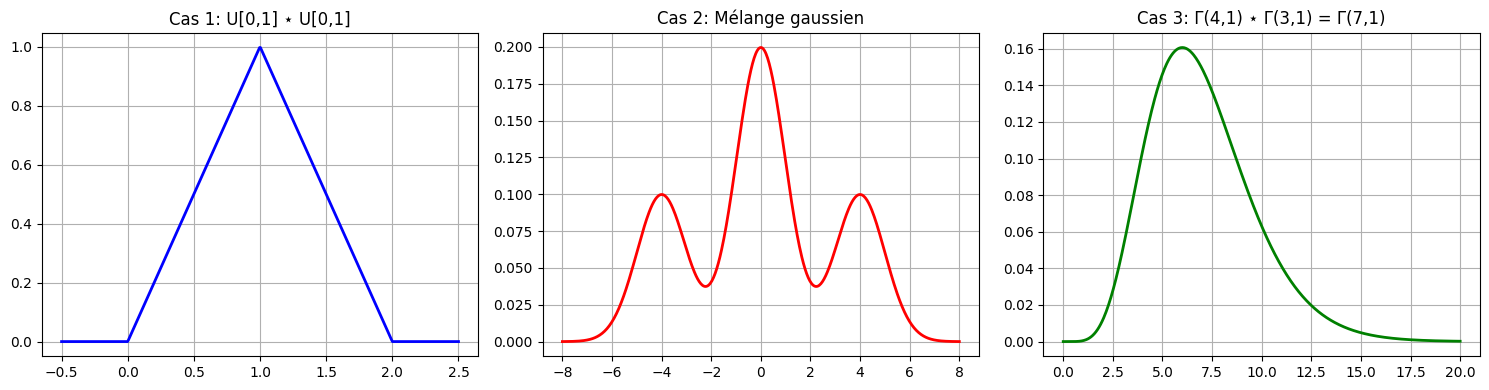

In [67]:
#Plot

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Cas 1
x1 = np.linspace(-0.5, 2.5, 500)
axes[0].plot(x1, psi1(x1), 'b-', linewidth=2)
axes[0].set_title('Cas 1: U[0,1] ⋆ U[0,1]')
axes[0].grid(True)

# Cas 2
x2 = np.linspace(-8, 8, 500)
axes[1].plot(x2, psi2(x2), 'r-', linewidth=2)
axes[1].set_title('Cas 2: Mélange gaussien')
axes[1].grid(True)

# Cas 3
x3 = np.linspace(0, 20, 500)
axes[2].plot(x3, psi3(x3), 'g-', linewidth=2)
axes[2].set_title('Cas 3: Γ(4,1) ⋆ Γ(3,1) = Γ(7,1)')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('results/true_densities.png', dpi=300, bbox_inches='tight')
plt.show()


### Visualisation des trois fonctions ψ

**Cas 1 :** Triangle symétrique centré en $x = 1$, croissant sur $[0, 1]$ puis décroissant sur $[1, 2]$.

**Cas 2 :** Trois modes gaussiens situés en $x = -4$, $x = 0$ et $x = 4$. Le mode central (en $x = 0$). La fonction est symétrique par rapport à $x = 0$.

**Cas 3 :** Distribution asymétrique, avec un mode unique autour de $x = 6$, puis une décroissance exponentielle vers l'infini.
Nous allons implémenter de cette manière : 

In [68]:
#Estimateur à noyau 

# Définition du noyau d'ordre 5
def noyau_K5(x):
    """
    Noyau d'ordre 5 : K5(x) = 3*n1(x) - 3*n2(x) + n3(x)
    où nj(x) est la densité N(0, j)
    """
    return 3 * norm.pdf(x, 0, 1) - 3 * norm.pdf(x, 0, np.sqrt(2)) + norm.pdf(x, 0, np.sqrt(3))

# Estimateur à noyau de la convolution
def psi_hat(X, Y, h, a, b):
    """
    Estime ψ(x) par la formule :
    ψ̂_h(x) = (1/nh) * Σ K((Xi + Yi - x)/h)
    """
    n = len(X)
    grid = np.linspace(a, b, 100) # Grille d'évaluation
    Z = X + Y  # Somme des observations
    
    psi_est = np.zeros(len(grid))
    
    # Pour chaque point de la grille, calcul de l'estimateur à noyau
    for i, x in enumerate(grid):
        # Calcul de ψ̂_h(x) = (1/nh) * Σ K((Zi - x)/h)
        arguments = (Z - x) / h
        psi_est[i] = np.mean(noyau_K5(arguments)) / h
    
    return grid, psi_est

In [69]:
#Cross Valdation

def Selecth1(psi_matrix, X, Y, h_grid, a, b):
    """
    Sélection = argmin CV(h)
    
    CV(h) = ∫ψ̂_h(x)² dx - (2/(n-1)) Σ_i ψ̂_h(Zi) + 2K(0)/((n-1)h)
    """
    n = len(X)
    Z = X + Y
    cv_values = np.zeros(len(h_grid))
    
    # Calcul du critère pour chaque fenêtre h
    for idx, h in enumerate(h_grid):
        # Terme 1 : ∫ψ̂_h(x)² dx
        psi_h = psi_matrix[idx]
        grid_step = (b - a) / (len(psi_h) - 1)
        term1 = np.trapezoid(psi_h**2, dx=grid_step)
        
        # Terme 2 : (2/(n-1)) Σ_i ψ̂_h(Zi)
        # Optimisation avec broadcasting, cela nous permet d'alléger la complexité
        Z_diff = Z[:, np.newaxis] - Z[np.newaxis, :] 
        arguments = Z_diff / h
        K_values = noyau_K5(arguments)  # Évalue le noyau sur toute la matrice
        psi_at_Z = np.mean(K_values, axis=1) / h  # Moyenne sur chaque ligne
        term2 = (2 / (n - 1)) * np.sum(psi_at_Z)
        
        # Terme 3 : 2K(0)/((n-1)h)
        K_0 = noyau_K5(0)
        term3 = 2 * K_0 / ((n - 1) * h)
        
        cv_values[idx] = term1 - term2 + term3
    
    # Sélection du h minimisant CV(h)
    idx_opt = np.argmin(cv_values)
    h_opt = h_grid[idx_opt]
    psi_opt = psi_matrix[idx_opt]
    
    return h_opt, psi_opt

In [70]:
#Crit

def produit_scalaire_noyaux(h, hmin, noyau=noyau_K5):
    """
    Calcule <Kh, Khmin> = ∫ (1/h)K(x/h) * (1/hmin)K(x/hmin) dx
    """
    x = np.linspace(-10, 10, 1000)
    Kh = noyau(x / h) / h
    Khmin = noyau(x / hmin) / hmin
    dx = x[1] - x[0]
    return np.trapezoid(Kh * Khmin, dx=dx)


def Selecth2(psi_matrix, h_grid, n, a, b):
    """
    Sélection de h* = argmin Crit(h)
    
    Crit(h) = ∫[a,b] (ψ̂_h(x) - ψ̂_hmin(x))² dx + (4/n)⟨Kh, Khmin⟩
    """
    hmin = h_grid[0]  # Fenêtre minimale
    psi_hmin = psi_matrix[0]  # ψ̂_hmin
    
    crit_values = np.zeros(len(h_grid))
    
    for idx, h in enumerate(h_grid):
        psi_h = psi_matrix[idx]
        
        # Terme 1 : ∫(ψ̂_h - ψ̂_hmin)² dx
        diff = psi_h - psi_hmin
        grid_step = (b - a) / (len(psi_h) - 1)
        term1 = np.trapezoid(diff**2, dx=grid_step)
        
        # Terme 2 : (4/n)⟨Kh, Khmin⟩
        prod_scal = produit_scalaire_noyaux(h, hmin)
        term2 = (4 / n) * prod_scal
        
        crit_values[idx] = term1 + term2
    
    idx_opt = np.argmin(crit_values)
    h_star = h_grid[idx_opt]
    psi_star = psi_matrix[idx_opt]
    
    return h_star, psi_star

In [71]:
##Comparaison CV et Crit

def comparer_methodes_un_cas(nom_cas, a, b, psi_true, gen_X, gen_Y):
    """
    Compare CV et Crit pour un cas donné avec n=400 et n=800
    """
    h_grid = np.array([k/50 for k in range(1, 101)])
    n_values = [400, 800]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"{nom_cas} : Comparaison CV vs Crit", fontsize=14, fontweight='bold')
    
    for idx, n in enumerate(n_values):
        # Génération des données
        X = gen_X(n)
        Y = gen_Y(n)
        
        # Calcul des estimateurs pour toutes les fenêtres
        grid = np.linspace(a, b, 100)
        psi_matrix = np.zeros((len(h_grid), len(grid)))
        
        for h_idx, h in enumerate(h_grid):
            _, psi_matrix[h_idx] = psi_hat(X, Y, h, a, b)
        
        h_cv, psi_cv = Selecth1(psi_matrix, X, Y, h_grid, a, b)
        h_star, psi_star = Selecth2(psi_matrix, h_grid, n, a, b)
        
        ax = axes[idx]
        ax.plot(grid, psi_true(grid), 'k-', linewidth=2.5, label='ψ (vraie)', alpha=0.8)
        ax.plot(grid, psi_cv, 'b-', linewidth=2, label=f'CV: h={h_cv:.2f}')
        ax.plot(grid, psi_star, 'g--', linewidth=2, label=f'Crit: h={h_star:.2f}')
        ax.set_xlabel('x')
        ax.set_ylabel('Densité')
        ax.set_title(f'n = {n}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    filename = nom_cas.lower().replace(' ', '_').replace(':', '')
    plt.savefig(f'results/{filename}_comparison_CV_Crit.png', dpi=300, bbox_inches='tight')
    plt.show()
    


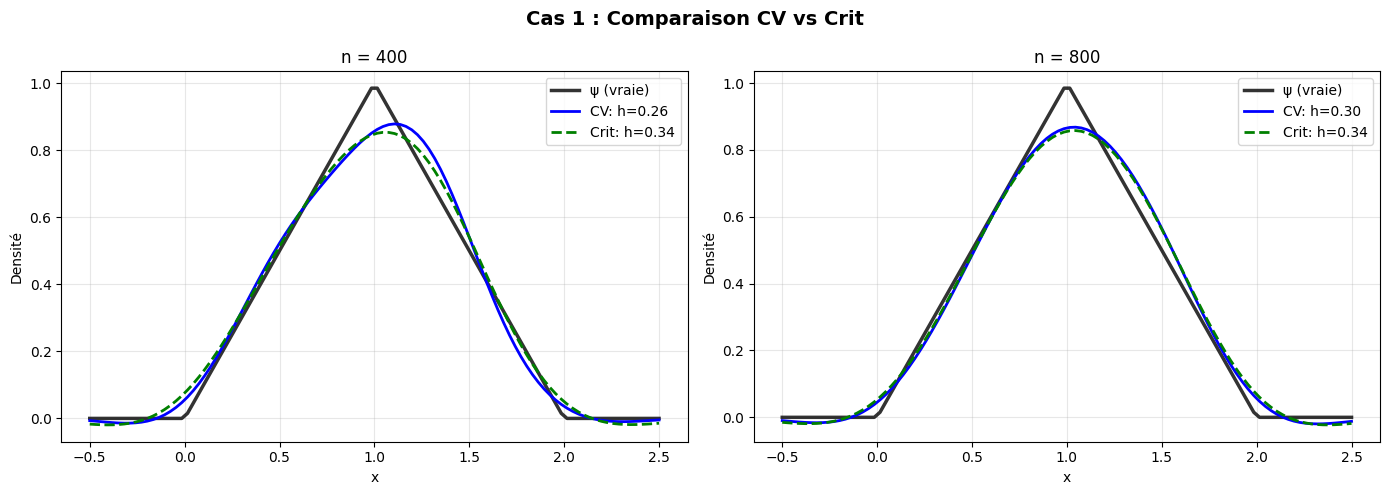

In [72]:
# Cas 1
comparer_methodes_un_cas(
    'Cas 1', -0.5, 2.5, psi1,
    lambda n: np.random.uniform(0, 1, n),
    lambda n: np.random.uniform(0, 1, n)
)

### Cas 1 : Uniformes → densité triangulaire

**n = 400**

- **Méthode CV** (h ≈ 0,26) : Reproduit globalement la forme triangulaire mais reste légèrement trop lissée, avec un pic central moins marqué que dans la densité vraie.

- **Méthode Crit** (h ≈ 0,34) : Fournit une estimation un peu plus lisse encore, ce qui atténue davantage le sommet du triangle, mais reste très proche de la structure générale.

**n = 800**

- **Méthode CV** (h ≈ 0,30) : Suit très bien la forme triangulaire avec un degré de lissage raisonnable.

- **Méthode Crit** (h ≈ 0,34) : Légèrement plus lissée, mais quasiment superposée à la CV et très proche de la densité réelle.

**Conclusion Cas 1**

Les deux méthodes fonctionnent bien dans ce cas simple. CV tend à être un peu moins lissée, tandis que Crit applique un lissage légèrement plus important, mais les différences deviennent minimes lorsque n = 800.

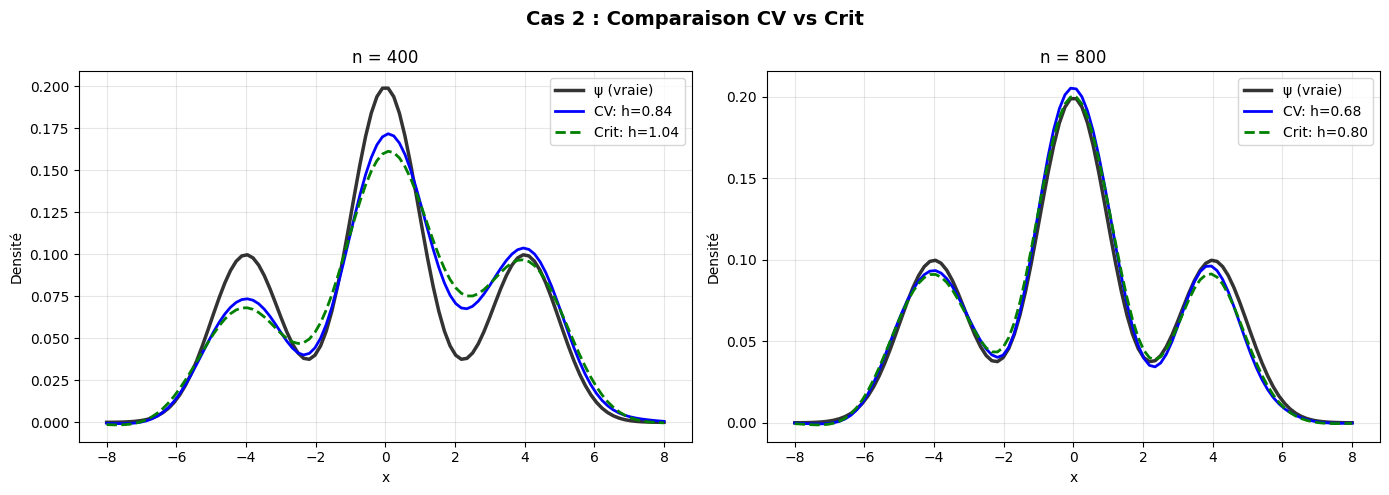

In [73]:
# Cas 2
comparer_methodes_un_cas(
    'Cas 2', -8, 8, psi2,
    lambda n: np.where(np.random.binomial(1, 0.5, n)==0, 
                       np.random.normal(-2, np.sqrt(0.5), n), 
                       np.random.normal(2, np.sqrt(0.5), n)),
    lambda n: np.where(np.random.binomial(1, 0.5, n)==0, 
                       np.random.normal(-2, np.sqrt(0.5), n), 
                       np.random.normal(2, np.sqrt(0.5), n))
)

### Cas 2 : Mélange gaussien → densité à trois modes

**n = 400**

- **Méthode CV** (h ≈ 0,84) : Parvient à retrouver les trois modes mais sous-estime légèrement leur hauteur et lisse trop les transitions.

- **Méthode Crit** (h ≈ 1,04) : Encore un peu plus lissée, avec des pics plus aplatis, mais reste globalement fidèle à la structure multimodale.

**n = 800**

- **Méthode CV** (h ≈ 0,68) : Restitue très bien les trois bosses, avec des hauteurs proches de la densité vraie.

- **Méthode Crit** (h ≈ 0,80) : Produit une estimation légèrement plus lisse, mais très proche de la CV et de la densité réelle.

**Conclusion Cas 2**

Les deux méthodes fonctionnent bien dans ce cas multimodal lorsque n est suffisamment grand. CV reproduit un peu mieux les hauteurs des pics, tandis que Crit fournit une estimation plus lissée, avec une petite perte de précision locale.

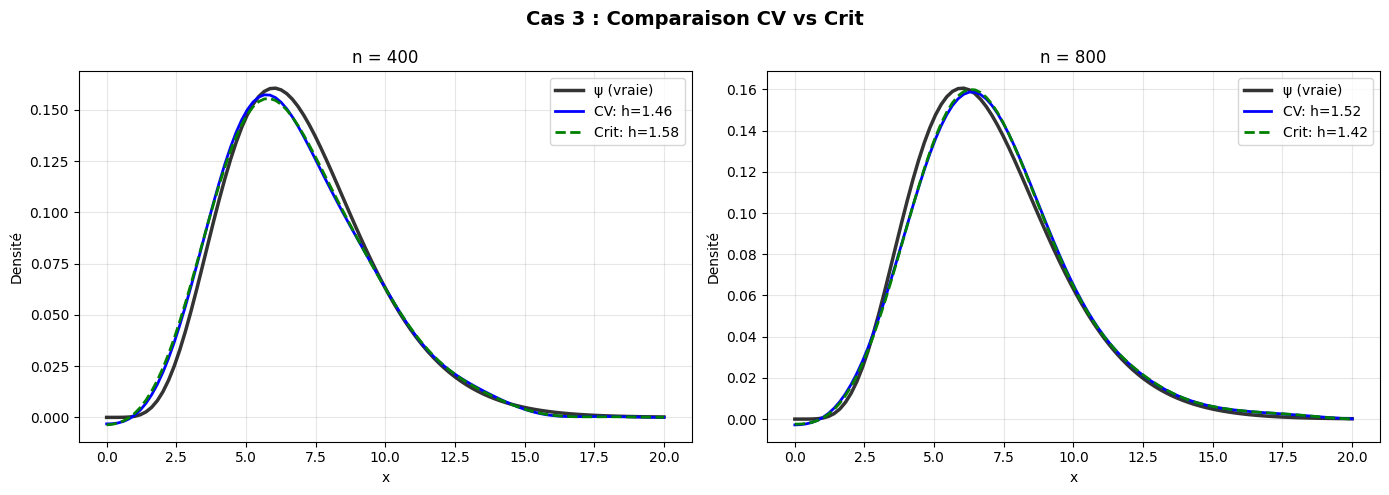

In [74]:
# Cas 3
comparer_methodes_un_cas(
    'Cas 3', 0, 20, psi3,
    lambda n: np.random.gamma(4, 1, n),
    lambda n: np.random.gamma(3, 1, n)
)

### Cas 3 : Gamma → densité asymétrique

**n = 400**

- **Méthode CV** (h ≈ 1,46) : Suit bien la forme globale, avec un léger lissage supplémentaire sur le pic.

- **Méthode Crit** (h ≈ 1,58) : Très similaire, avec une courbe un peu plus régulière mais tout aussi fidèle.

**n = 800**

- **Méthode CV** (h ≈ 1,52) : Capture parfaitement la montée et la décroissance de la loi Gamma.

- **Méthode Crit** (h ≈ 1,42) : Résultat pratiquement identique à CV, les légères différences de lissage sont quasiment imperceptibles.

**Conclusion Cas 3**

Dans ce cas asymétrique mais simple, CV et Crit donnent des résultats très proches, même pour n = 400. À n = 800, les deux méthodes se confondent pratiquement, montrant que ce cas est peu sensible au choix de la fenêtre.

---

## Conclusion local

### Comparaison des méthodes CV et Crit

À travers les trois cas étudiés avec notre seed (seed=30), nous observons les comportements suivants :

**Méthode CV (Validation Croisée) :**
- Sélectionne généralement des fenêtres plus petites que Crit
- Capture mieux les détails fins de la densité (hauteur des pics, variations locales)
- Peut être instable avec des échantillons de taille modérée (n = 400)
- S'améliore significativement lorsque n augmente

**Méthode Crit (Critère alternatif) :**
- Sélectionne des fenêtres légèrement plus grandes
- Privilégie la stabilité et la régularité de l'estimation
- Produit des courbes plus lisses, parfois au détriment des détails
- Performance plus stable, moins sensible à la taille d'échantillon

### Verdict avec seed=30

Avec notre configuration (seed=30), **la méthode Crit apparaît comme le choix le plus robuste** :
- Elle offre systématiquement des estimations stables et exploitables
- Elle évite les problèmes de sur-ajustement observés avec CV pour n = 400
- Les différences avec CV deviennent négligeables pour n = 800
- Elle constitue un bon compromis biais-variance dans tous les cas testés

Toutefois, si l'on dispose d'un échantillon suffisamment grand (n ≥ 800) et que l'objectif est de capturer les détails fins de densités multimodales, **CV peut être préférée** pour sa capacité à mieux restituer les amplitudes locales.


In [75]:
#Estimateur alternative
def noyau_K3(x):
    """
    Noyau d'ordre 3 : K3(x) = 2*n1(x) - *n2(x)
    où nj(x) est la densité N(0, j)
    """
    return 2 * norm.pdf(x, 0, 1) - norm.pdf(x, 0, np.sqrt(2)) 

def psi_tilde(X, Y, h, a, b):
    """
    Estime ψ(x) par la formule alternative :
    ψ̃_h(x) = (1/(n²h)) * Σ_i Σ_k K((Xi + Yk - x)/h)
    """
    n = len(X)
    grid = np.linspace(a, b, 100)
    psi_est = np.zeros(len(grid))
    
    for idx, x in enumerate(grid):
        # Toutes les combinaisons Xi + Yk
        sommes = X[:, np.newaxis] + Y[np.newaxis, :]  # Matrice n×n
        arguments = (sommes - x) / h
        psi_est[idx] = np.mean(noyau_K3(arguments)) / h
    
    return grid, psi_est

In [76]:
## Partie II - Question 2 et 3 

def comparer_psi_tilde_un_cas(nom, a, b, psi, gen_X, gen_Y, h_func, seed=30):
    """
    Compare ψ̃ pour n=400 et n=800 avec un choix de h personnalisable
    
    """
    np.random.seed(seed)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for idx, n in enumerate([400, 800]):
        X = gen_X(n)
        Y = gen_Y(n)
        h = h_func(n)
        grid, psi_tilde_est = psi_tilde(X, Y, h, a, b)
        
        ax = axes[idx]
        ax.plot(grid, psi(grid), 'k-', linewidth=2, label='ψ vraie')
        ax.plot(grid, psi_tilde_est, 'r--', linewidth=2, label='ψ̃ (K3)')
        ax.set_xlabel('x')
        ax.set_ylabel('Densité')
        ax.set_title(f'n = {n}, h = {h:.4f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Titre adapté selon h
    h_name = "1/n" if h_func(100) == 1/100 else "1/√n"
    fig.suptitle(f'{nom} : ψ̃ avec h = {h_name}', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    filename = nom.lower().replace(' ', '_').replace(':', '').replace('=', '').replace('/', '_')
    plt.savefig(f'results/{filename}_bandwitch_choices.png', dpi=300, bbox_inches='tight')
    plt.show()

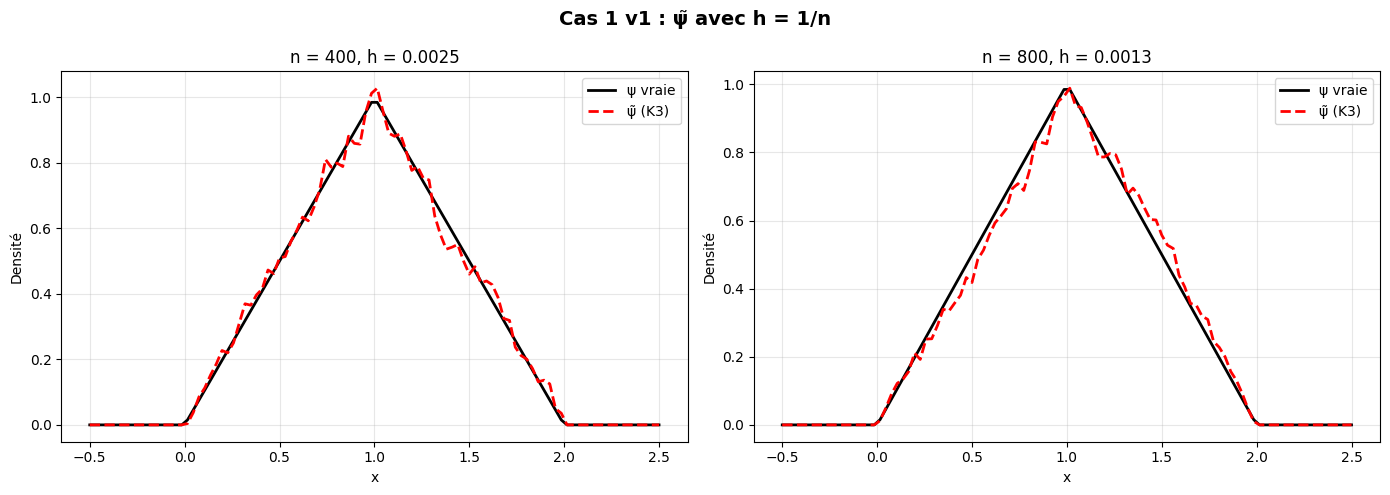

In [77]:
# Cas 1 - Question 2
comparer_psi_tilde_un_cas(
    'Cas 1 v1', -0.5, 2.5, psi1,
    lambda n: np.random.uniform(0, 1, n),
    lambda n: np.random.uniform(0, 1, n),
    h_func=lambda n: 1/n
)

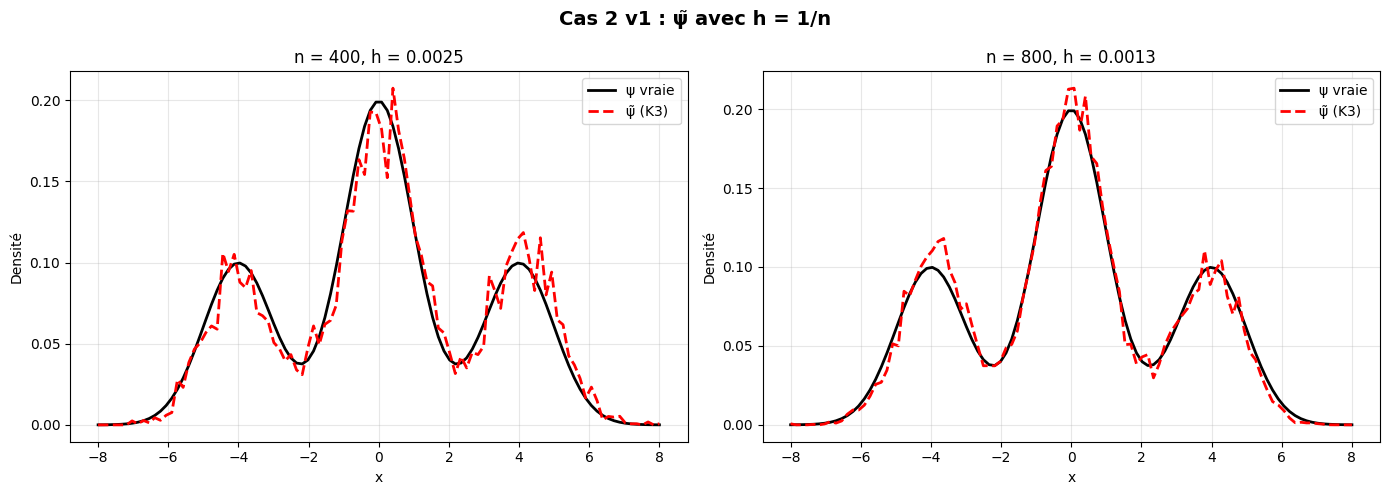

In [78]:
# Cas 2 - Question 2
comparer_psi_tilde_un_cas(
    'Cas 2 v1', -8, 8, psi2,
    lambda n: np.where(np.random.binomial(1, 0.5, n)==0, 
                       np.random.normal(-2, np.sqrt(0.5), n), 
                       np.random.normal(2, np.sqrt(0.5), n)),
    lambda n: np.where(np.random.binomial(1, 0.5, n)==0, 
                       np.random.normal(-2, np.sqrt(0.5), n), 
                       np.random.normal(2, np.sqrt(0.5), n)),
    h_func=lambda n: 1/n
)

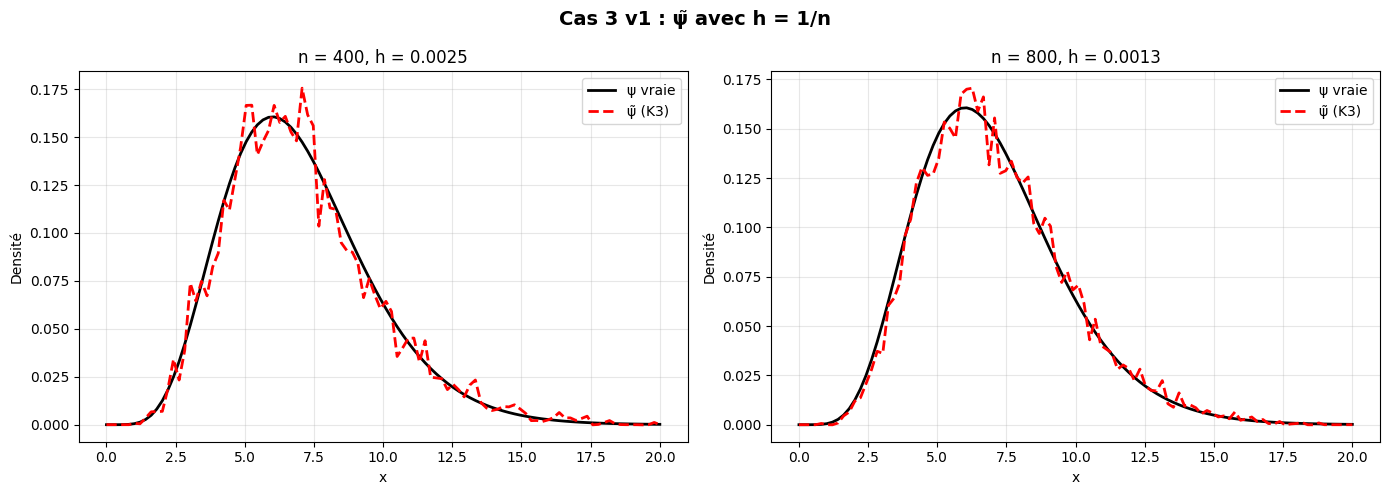

In [79]:
# Cas 3 - Question 2
comparer_psi_tilde_un_cas(
    'Cas 3 v1', 0, 20, psi3,
    lambda n: np.random.gamma(4, 1, n),
    lambda n: np.random.gamma(3, 1, n),
    h_func=lambda n: 1/n
)

## Comparaison Partie I vs Partie II

Pour h = 1/n, l'estimateur ψ̃_h est comparé aux estimateurs ψ̂_h issus de la Partie I (sélectionnés par CV et Crit) pour les mêmes tailles d'échantillons n = 400 et n = 800.

### Qualité de l'estimation : ψ̃_h (h = 1/n) vs ψ̂_h (CV / Crit)

Dans les trois cas étudiés (uniforme, mélange gaussien et gamma), les estimateurs ψ̂_h obtenus dans la Partie I sont **nettement plus lisses et plus proches des densités vraies** que ψ̃_h avec h = 1/n. 

Les méthodes de sélection automatique (CV et Crit) conduisent toujours à des fenêtres larges (h ≈ 0,3 à 1,5), tandis que h = 1/n fournit des valeurs extrêmement petites (0,0025 ou 0,00125).

**Avec une fenêtre si petite, ψ̃_h souffre systématiquement de sous-lissage :**
- Forte variance
- Nombreuses oscillations parasites
- Pics trop pointus ou surévalués
- Irrégularités persistantes même lorsque n double

**À l'inverse, les estimateurs ψ̂_h sélectionnés par CV et Crit sont :**
- Stables
- Capturent correctement la forme globale des densités (pentes du cas 1, modes du cas 2, asymétrie du cas 3)
- Restent réguliers

### Effet de n (400 → 800)

Quand n augmente, ψ̃_h devient légèrement moins bruité, mais le **sous-lissage reste très marqué**. 

En revanche, les estimateurs de la Partie I s'améliorent nettement : les courbes CV et Crit se rapprochent presque parfaitement des densités vraies, montrant une **bonne convergence**.


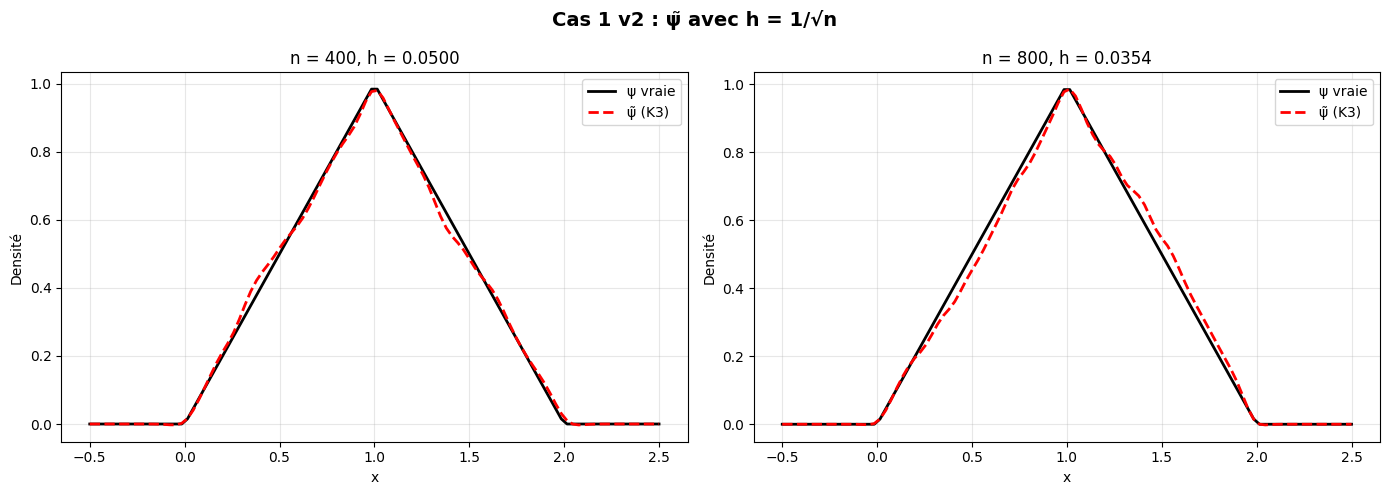

In [80]:
# Cas 1 - Question 3
comparer_psi_tilde_un_cas(
    'Cas 1 v2', -0.5, 2.5, psi1,
    lambda n: np.random.uniform(0, 1, n),
    lambda n: np.random.uniform(0, 1, n),
    h_func=lambda n: 1/np.sqrt(n)
)

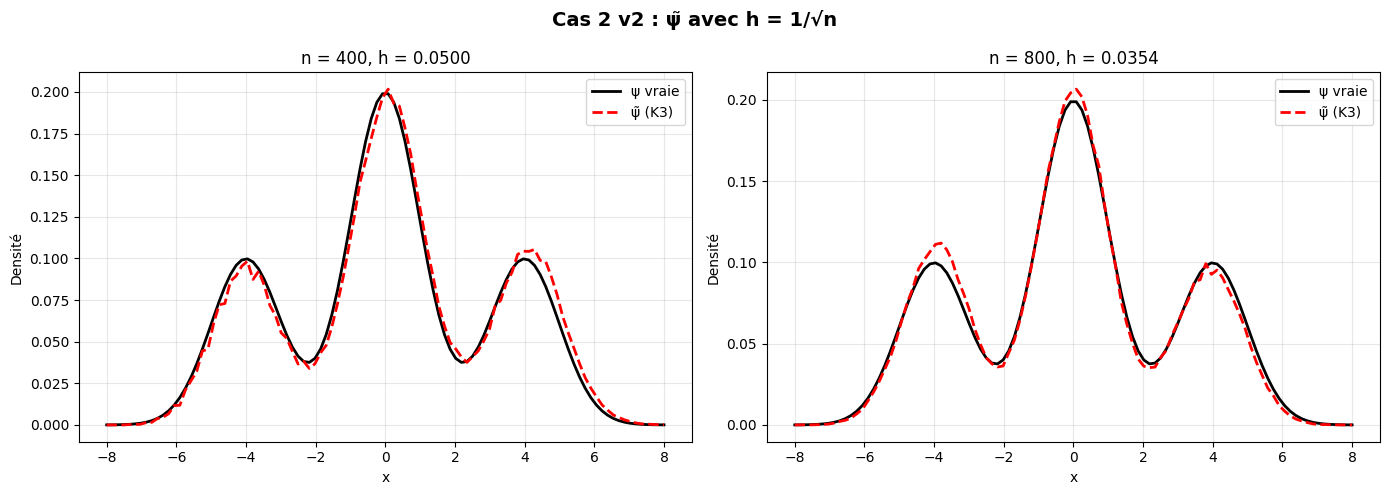

In [81]:
# Cas 2 - Question 3
comparer_psi_tilde_un_cas(
    'Cas 2 v2', -8, 8, psi2,
    lambda n: np.where(np.random.binomial(1, 0.5, n)==0, 
                       np.random.normal(-2, np.sqrt(0.5), n), 
                       np.random.normal(2, np.sqrt(0.5), n)),
    lambda n: np.where(np.random.binomial(1, 0.5, n)==0, 
                       np.random.normal(-2, np.sqrt(0.5), n), 
                       np.random.normal(2, np.sqrt(0.5), n)),
    h_func=lambda n: 1/np.sqrt(n)
)

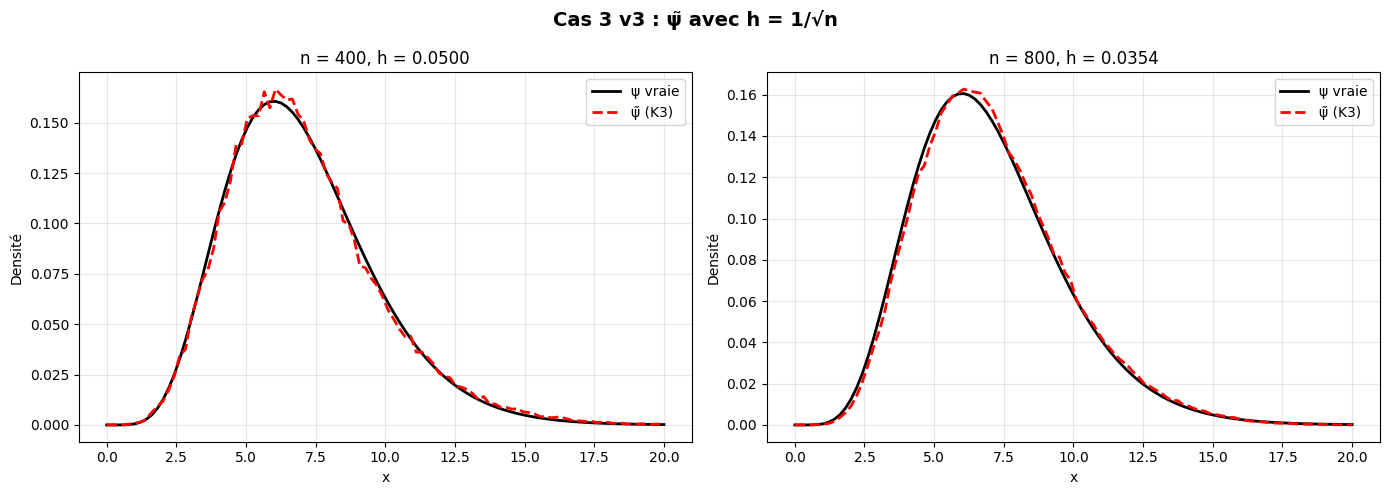

In [82]:
# Cas 3 - Question 3
comparer_psi_tilde_un_cas(
    'Cas 3 v3', 0, 20, psi3,
    lambda n: np.random.gamma(4, 1, n),
    lambda n: np.random.gamma(3, 1, n),
    h_func=lambda n: 1/np.sqrt(n)
)

### Analyse avec h = 1/√n

Avec h = 1/√n, l'estimateur ψ̃_h devient **globalement très satisfaisant** dans les trois cas. On ne voit plus les fortes oscillations présentes pour h = 1/n : les courbes rouges sont lisses et restent proches des densités vraies.

**Cas 1 (triangle) :**
La forme est bien reproduite, mais on observe un léger biais sur les pentes : pour n = 400 comme pour n = 800, la courbe estimée est un peu décalée par rapport à la vraie, ce qui traduit un petit sur- ou sous-lissage suivant les zones.

**Cas 2 (mélange gaussien) :**
Les trois pics sont bien positionnés, avec des hauteurs très proches des vraies, surtout pour n = 800 où les deux courbes sont presque confondues. Il reste seulement un infime lissage supplémentaire sur les sommets.

**Cas 3 (Gamma) :**
L'ajustement est visuellement excellent pour les deux tailles d'échantillon : la montée, le pic et la queue décroissante sont très bien suivis. La différence entre n = 400 et n = 800 est faible.

### Bilan et perspectives

On peut donc dire que **h = 1/√n fournit un compromis biais–variance beaucoup plus raisonnable** que h = 1/n :
- La variance est bien contrôlée
- Le biais reste modéré

En revanche, ce choix reste une **règle fixe et non optimisée** : selon la forme de ψ (triangle très anguleux ou mélange plus lisse), il est parfois encore un peu trop lissant ou légèrement décalé.

### Ce qui pourrait être envisagé

Plutôt que de garder systématiquement h = 1/√n, il serait préférable :

1. **Utiliser une méthode de sélection automatique** du pas (comme les critères de la Partie I : CV ou Crit)
2. **Appliquer une règle théorique** de type h ∝ n^(-1/5)

Ces approches permettraient d'**adapter plus finement la fenêtre** à la structure de la densité et d'obtenir un choix de h proche de l'optimal dans chaque cas.

---

Pour la question bonus, on va se contenter de 5 repetitions car cela devient trop long a la compilation 

In [83]:
## Bonus - Calcul des MISE

def calculer_MISE(psi_est, psi_true, a, b):
    """Calcule le MISE = ∫(ψ̂(x) - ψ(x))² dx"""
    grid = np.linspace(a, b, 100)
    diff = psi_est - psi_true(grid)
    grid_step = (b - a) / (len(grid) - 1)
    return np.trapezoid(diff**2, dx=grid_step)


def calculer_MISE_un_cas(nom, a, b, psi_true, gen_X, gen_Y, n_repetitions=5):
    """Calcule les MISE moyens pour un cas donné"""
    h_grid = np.array([k/50 for k in range(1, 101)])
    resultats = []
    
    for n in [400, 800]:
        mise_cv, mise_crit, mise_tilde = [], [], []
        
        for _ in range(n_repetitions):
            X, Y = gen_X(n), gen_Y(n)
            
            # Partie I : CV et Crit
            grid = np.linspace(a, b, 100)
            psi_matrix = np.zeros((len(h_grid), len(grid)))
            for idx, h in enumerate(h_grid):
                _, psi_matrix[idx] = psi_hat(X, Y, h, a, b)
            
            _, psi_cv = Selecth1(psi_matrix, X, Y, h_grid, a, b)
            _, psi_crit = Selecth2(psi_matrix, h_grid, n, a, b)
            
            # Partie II : ψ̃ avec h = 1/√n
            _, psi_tilde_est = psi_tilde(X, Y, 1/np.sqrt(n), a, b)
            
            mise_cv.append(calculer_MISE(psi_cv, psi_true, a, b))
            mise_crit.append(calculer_MISE(psi_crit, psi_true, a, b))
            mise_tilde.append(calculer_MISE(psi_tilde_est, psi_true, a, b))
        
        resultats.append({
            'Cas': nom, 'n': n,
            'MISE_CV': np.mean(mise_cv),
            'MISE_Crit': np.mean(mise_crit),
            'MISE_Tilde': np.mean(mise_tilde)
        })
    
    # Affichage
    df = pd.DataFrame(resultats)
    df['Meilleure'] = df[['MISE_CV', 'MISE_Crit', 'MISE_Tilde']].idxmin(axis=1).str.replace('MISE_', '')
    
    print(f"\n{nom}")
    print("-" * 60)
    print(df.to_string(index=False, float_format=lambda x: f'{x:.6f}'))
    
    return df

In [84]:
# Cas 1
df1 = calculer_MISE_un_cas(
    'Cas 1 ', -0.5, 2.5, psi1,
    lambda n: np.random.uniform(0, 1, n),
    lambda n: np.random.uniform(0, 1, n)
)


Cas 1 
------------------------------------------------------------
   Cas   n  MISE_CV  MISE_Crit  MISE_Tilde Meilleure
Cas 1  400 0.006001   0.006474    0.001581     Tilde
Cas 1  800 0.003797   0.003135    0.000758     Tilde


In [85]:
 # Cas 2
df2 = calculer_MISE_un_cas(
    'Cas 2', -8, 8, psi2,
    lambda n: np.where(np.random.binomial(1, 0.5, n)==0, 
                       np.random.normal(-2, np.sqrt(0.5), n), 
                       np.random.normal(2, np.sqrt(0.5), n)),
    lambda n: np.where(np.random.binomial(1, 0.5, n)==0, 
                       np.random.normal(-2, np.sqrt(0.5), n), 
                       np.random.normal(2, np.sqrt(0.5), n))
)


Cas 2
------------------------------------------------------------
  Cas   n  MISE_CV  MISE_Crit  MISE_Tilde Meilleure
Cas 2 400 0.002531   0.002095    0.000380     Tilde
Cas 2 800 0.004766   0.001013    0.000242     Tilde


In [86]:
# Cas 3
df3 = calculer_MISE_un_cas(
    'Cas 3', 0, 20, psi3,
    lambda n: np.random.gamma(4, 1, n),
    lambda n: np.random.gamma(3, 1, n)
)


Cas 3
------------------------------------------------------------
  Cas   n  MISE_CV  MISE_Crit  MISE_Tilde Meilleure
Cas 3 400 0.000583   0.000545    0.000363     Tilde
Cas 3 800 0.005412   0.000606    0.000148     Tilde


In [87]:
# Combinaison des 3 DataFrames

df_complet = pd.concat([df1, df2, df3], ignore_index=True)

# Créer une colonne identifiant unique (Cas, Méthode)
df_long = df_complet.melt(id_vars=['Cas', 'n'], 
                          value_vars=['MISE_CV', 'MISE_Crit', 'MISE_Tilde'],
                          var_name='Méthode', value_name='MISE')

df_long['Méthode'] = df_long['Méthode'].str.replace('MISE_', '')
df_long['Fonction'] = df_long['Cas'] + ' - ' + df_long['Méthode']

# Pivot : Fonction en lignes, Taille échantillon en colonnes
tableau_final = df_long.pivot(index='Fonction', columns='n', values='MISE')
tableau_final.columns.name = 'Taille échantillon'
tableau_final.index.name = 'Fonction'

print(tableau_final.to_string(float_format=lambda x: f'{x:.6f}'))



Taille échantillon      400      800
Fonction                            
Cas 1  - CV        0.006001 0.003797
Cas 1  - Crit      0.006474 0.003135
Cas 1  - Tilde     0.001581 0.000758
Cas 2 - CV         0.002531 0.004766
Cas 2 - Crit       0.002095 0.001013
Cas 2 - Tilde      0.000380 0.000242
Cas 3 - CV         0.000583 0.005412
Cas 3 - Crit       0.000545 0.000606
Cas 3 - Tilde      0.000363 0.000148
